# Import libraries

In [2]:
from semseg_functions import load_imgs_labels,train_model,make_predictions
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

c:\Users\JOKER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [3]:
# Load the Data from pickle file.
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

# Splitting the Data into Training and Validation Sets. 
X_train,X_val,Y_train,Y_val=train_test_split(
  images,labels,
  # test_size=0.2: 20% of the data is reserved for validation and 80% for training.
  test_size=0.2,
  # The condition >= np.median(labels.mean((1, 2))) creates a binary mask (True/False) 
  # based on whether the mean value is above or below the median.
  stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),
  random_state=42
  )

# Converting Data to PyTorch Tensors
X_train,X_val,Y_train,Y_val=(
  torch.FloatTensor(X_train).permute((0,3,1,2)),
  torch.FloatTensor(X_val).permute((0,3,1,2)),
  torch.LongTensor(Y_train),
  torch.LongTensor(Y_val)
  )

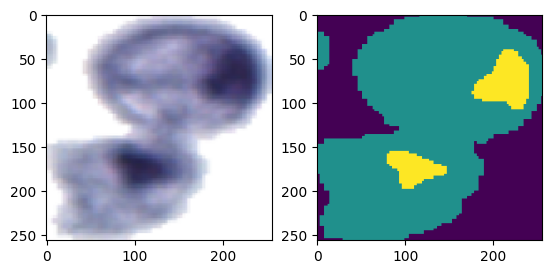

In [4]:
# plt.subplot(1, 2, 1) creates a 1-row, 2-column grid of subplots and selects the first subplot (index 1) for plotting.
plt.subplot(1,2,1)
plt.imshow(images[0])
# selects the second subplot (index 2) for plotting.
plt.subplot(1,2,2)
plt.imshow(labels[0])

# Train model

In [5]:
# Calls a function train_model from semseg_functions.py to train a deep learning model
# resnet34 refers to the ResNet-34 architecture, a popular convolutional neural network (CNN) backbone.
# FPN stands for Feature Pyramid Network, a popular architecture for tasks like object detection and segmentation.
model=train_model(X_train,Y_train,X_val,Y_val, encoder_name="resnet34", model_key="FPN", n_epochs=25)

Training: Epoch 1, Batch 0, Loss: 1.265
Training: Epoch 1, Batch 1, Loss: 1.128
Training: Epoch 1, Batch 2, Loss: 0.953
Training: Epoch 1, Batch 3, Loss: 0.84
Training: Epoch 1, Batch 4, Loss: 0.748
Training: Epoch 1, Batch 5, Loss: 0.681
Training: Epoch 1, Batch 6, Loss: 0.56
Training: Epoch 1, Batch 7, Loss: 0.538
Training: Epoch 1, Batch 8, Loss: 0.478
Training: Epoch 1, Batch 9, Loss: 0.484
Training: Epoch 1, Batch 10, Loss: 0.642
Training: Epoch 1, Batch 11, Loss: 0.428
Training: Epoch 1, Batch 12, Loss: 0.467
Training: Epoch 1, Batch 13, Loss: 0.413
Training: Epoch 1, Batch 14, Loss: 0.39
Training: Epoch 1, Batch 15, Loss: 0.441
Training: Epoch 1, Batch 16, Loss: 0.363
Training: Epoch 1, Batch 17, Loss: 0.302
Training: Epoch 1, Batch 18, Loss: 0.396
Training: Epoch 1, Batch 19, Loss: 0.319
Val: Epoch 1, Loss: 1.769
Training: Epoch 2, Batch 0, Loss: 0.344
Training: Epoch 2, Batch 1, Loss: 0.363
Training: Epoch 2, Batch 2, Loss: 0.262
Training: Epoch 2, Batch 3, Loss: 0.329
Trainin

# Predict on held out test

In [6]:
# calls a function make_predictions to generate predictions (y_val_pred) for the validation data (X_val)
# Since model_key="FPN" is passed to the train_model function, the FPN model is selected and used for prediting.
y_val_pred=make_predictions(X_val, encoder_name="resnet34", model_key="FPN")#,model=model)#model=None)

In [7]:
y_val_pred_lbls=y_val_pred.argmax(1)

# Report segmentation model performance

In [8]:
from sklearn.metrics import classification_report

In [9]:
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    980301
           1       0.93      0.87      0.90   1117270
           2       0.80      0.90      0.85    523869

    accuracy                           0.92   2621440
   macro avg       0.90      0.92      0.91   2621440
weighted avg       0.92      0.92      0.92   2621440



# Compare true and predicted NC ratios

In [10]:
nucleus_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==2).sum(axis=1)
cytoplasm_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==1).sum(axis=1)
nc_ratio_pred=nucleus_pred/(nucleus_pred+cytoplasm_pred)

In [11]:
nucleus_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_true=nucleus_true/(nucleus_true+cytoplasm_true)

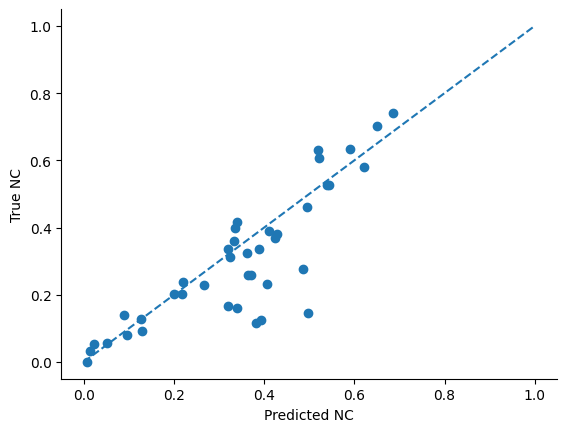

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(nc_ratio_pred,nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

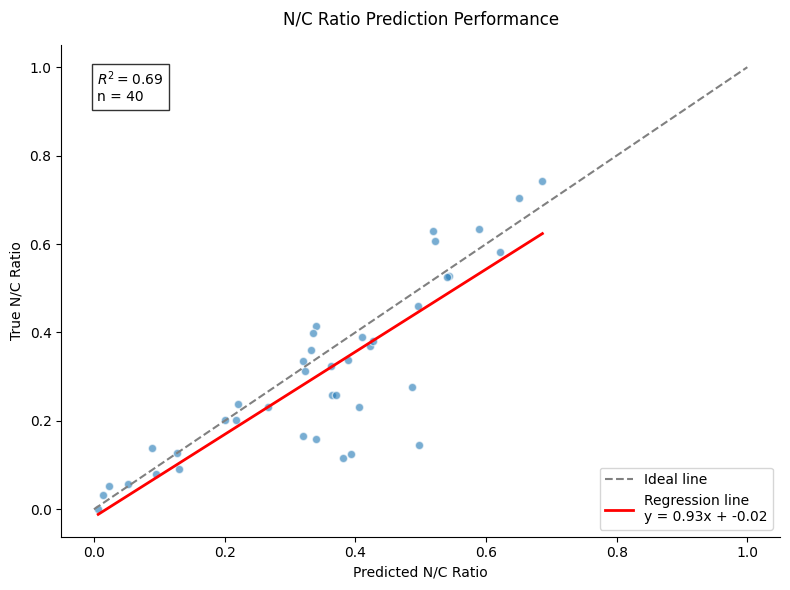

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


plt.figure(figsize=(8, 6))
plt.scatter(nc_ratio_pred, nc_ratio_true, alpha=0.6, edgecolor='w')

reg = LinearRegression().fit(nc_ratio_pred.reshape(-1, 1), nc_ratio_true)
slope = reg.coef_[0]
intercept = reg.intercept_
r2 = r2_score(nc_ratio_true, nc_ratio_pred)

x_range = np.linspace(min(nc_ratio_pred), max(nc_ratio_pred), 100)
y_reg = reg.predict(x_range.reshape(-1, 1))

plt.plot([0, 1], [0, 1], ls="--", c='gray', label='Ideal line')  
plt.plot(x_range, y_reg, c='red', lw=2, 
         label=f'Regression line\ny = {slope:.2f}x + {intercept:.2f}')

plt.text(0.05, 0.95, 
         f'$R^2 = {r2:.2f}$\nn = {len(nc_ratio_true)}', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Predicted N/C Ratio")
plt.ylabel("True N/C Ratio")
plt.title("N/C Ratio Prediction Performance", pad=15)
plt.legend(loc='lower right', frameon=True)
sns.despine()

plt.tight_layout()
plt.show()

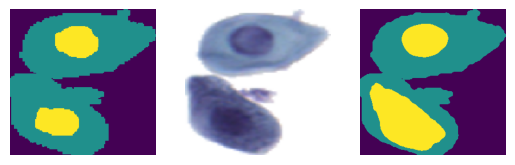

In [14]:
# ! mkdir DL_result_imgs
for idx in range(len(X_val)):
    plt.subplot(131)
    plt.imshow(Y_val[idx])
    plt.axis("off")
    plt.subplot(132)
    plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(y_val_pred_lbls[idx])
    plt.axis("off")
    plt.savefig(f"DL_result_imgs/urothelial_cell_{idx}.png")

In [15]:
# correlation - true vs predicted
spearmanr(nc_ratio_pred,nc_ratio_true)

SignificanceResult(statistic=np.float64(0.8138836772983116), pvalue=np.float64(1.708980529784619e-10))

In [16]:
# error - true vs predicted
np.abs(nc_ratio_pred-nc_ratio_true.numpy()).mean()

np.float64(0.07283165415935812)

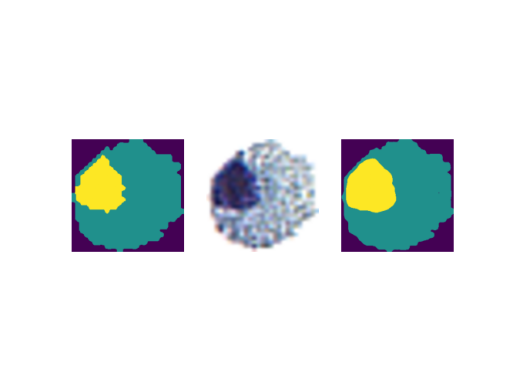

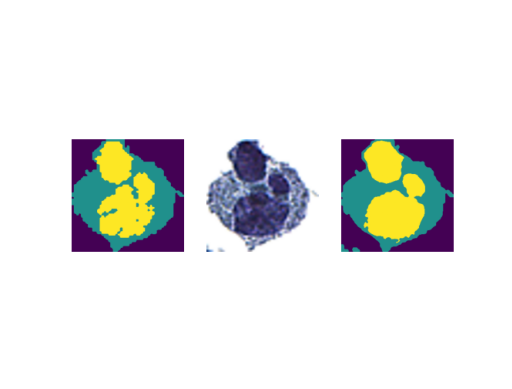

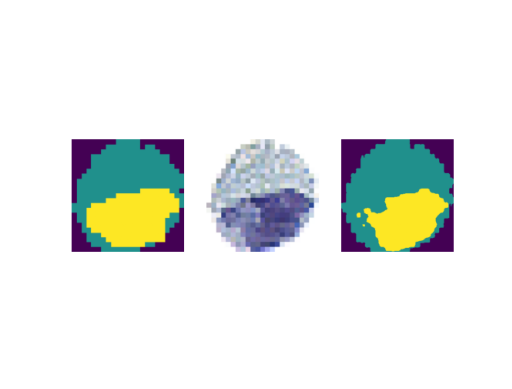

In [17]:
import matplotlib.pyplot as plt
result_images="""DL_result_imgs/urothelial_cell_11.png
DL_result_imgs/urothelial_cell_21.png
DL_result_imgs/urothelial_cell_22.png""".splitlines()

for img in result_images:
    plt.figure()
    plt.imshow(plt.imread(img))
    plt.axis("off")
    plt.show()
